# 5 Traits Model
> In psychological trait theory, the Big Five personality traits, also known as the five-factor model (FFM) and the OCEAN model, is a suggested taxonomy, or grouping, for personality traits, developed from the 1980s onwards. When factor analysis (a statistical technique) is applied to personality survey data, some words used to describe aspects of personality are often applied to the same person. For example, someone described as conscientious is more likely to be described as "always prepared" rather than "messy". This theory is based therefore on semantic associations between words and not on neuropsychological experiments. This theory uses descriptors of common language and suggests five broad dimensions commonly used to describe the human personality and psyche.
The theory identifies five factors:
> - openness to experience (inventive/curious vs. consistent/cautious)
> - conscientiousness (efficient/organized vs. easy-going/careless)
> - extroversion (outgoing/energetic vs. solitary/reserved)
> - agreeableness (friendly/compassionate vs. challenging/detached)
> - neuroticism (sensitive/nervous vs. secure/confident)

[Big Five personality traits](https://en.wikipedia.org/wiki/Big_Five_personality_traits)

The questionare consists of 50 statements, on which person is asked to anwser (on 1 to 5 scale), how much ge agrees on the statement. The statements are divided into 5 groups assosited with the traits. On top of that, we have informations about the place, where survey took place. 


# Simple bayesian interpretation
![](images/5_traits_model_simple.svg)

In the Big 5 Peronality traits model, we assume that, that user personality can be described by 5 dimensional, orthogonal vector, where each dimension is orthogonal to each other (at least in respect to quiz questions). 

## Distributions
Each trait will be modeled as a Beta distribution, with \\( \alpha \\) and \\( \beta \\) conditioned on country. ie:
\begin{equation}
Openness \sim Beta(\alpha=\alpha_{openness}, \beta = \beta_{openness})
\end{equation}

At last, we assume that each statement agreement comes from a binomial dristribution, where n=4, and p=Trait, eg.

\begin{equation}
OPN_i^* \sim Binomial(n=4, p=Openness_c) + 1
\end{equation}

We do it for every question, for every sample. This way, we can interpret trait as measure of likelihood, that someone would agree with the statement (ie. we transform a 5-scale problem into binary problem, so that the trait can be interpreted as probability of someone agreeing with the question. The +1 comes from the fact, that opinions range from 1 - 5, rather that 0 - 4. The star in the notation means a standarized anwser. Some statements are reverse (ie. I dont like people in extraversion trait). By standarized statement we mean, that for such cases we flip the question into agreeing form (I like people) and change the anwser as following
\begin{equation}
OPN_i^* = 6 - OPN_i
\end{equation}

In [14]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
import pyro.distributions as dist
from src.common import N_COUNTIRES, load_joint, empty_df, positive_correlation, QUESTIONS, NEGATIVE_QUESTIONS, load_train_test
from src.BaseModel import BaseModel
from sklearn.preprocessing import OrdinalEncoder
import torch.distributions.constraints as const
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import display
from src.BigFiveModel import BigFiveModel
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Perform inference of latents for dataset colected via survey
We (and our friends) did a Five Traits psychological test ourselves. Here we present infered distributions over latent variables for these anwsers to statements.

In [15]:
data = pd.read_csv("dataset/test_results.csv")

users = {}
for _, row in data.iterrows():
    name = row[1]
    users[name] = {
        key: row.values[2 + i]
        for i, key in enumerate(QUESTIONS.keys())
    }

100%|██████████| 2500/2500 [00:13<00:00, 188.74it/s]


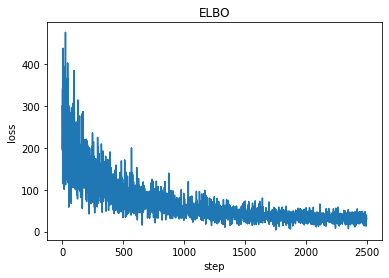

In [16]:
model = BigFiveModel()
for user, observations in users.items():
    model.observe(user, observations)
model.infer(2500)

## Latent trait distribution
Display a trait probability distribution for each user in the database, based on their statements. As we see, there is one highly neurotic personality.

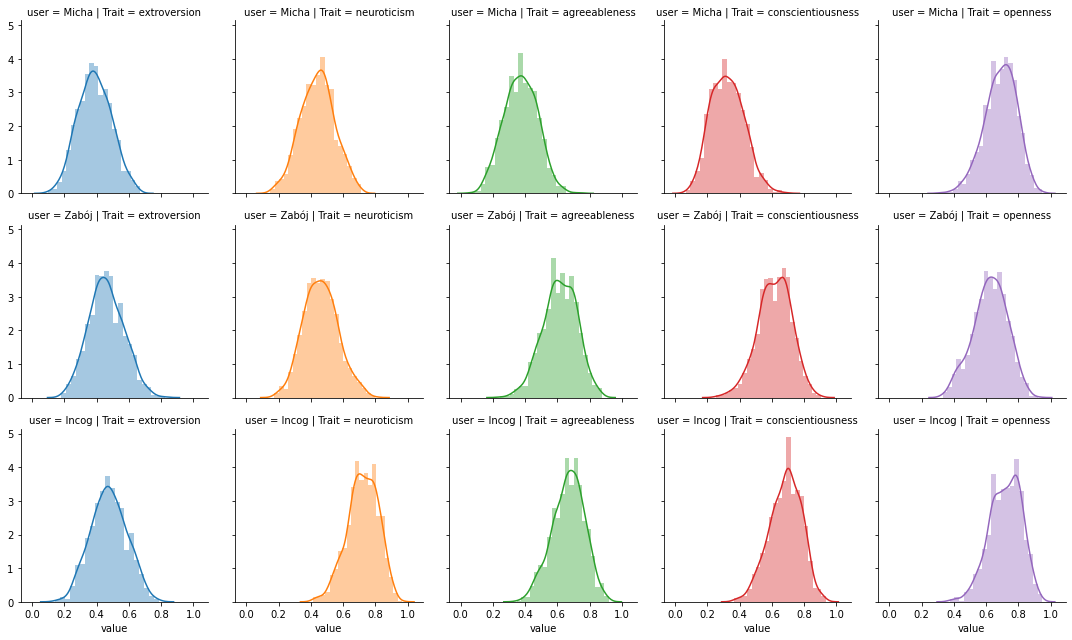

In [17]:
x = model.sample(1000)['trait'].detach().numpy().reshape(1000, 5, -1).transpose([2, 0, 1])

dfs = []
for i, user in enumerate(users.keys()):
    realistations = x[i, :, :]
    
    df = pd.DataFrame( {
        name: realistations[:, i]
        for i, name in enumerate(["extroversion", "neuroticism", "agreeableness", "conscientiousness", "openness"])
    })

    df = pd.melt(df, var_name="Trait")
    df['user'] = user[:5]
    
    dfs.append(df)

data_frame = pd.concat(dfs, ignore_index=True)

g = sns.FacetGrid(data=data_frame, row="user", col="Trait", hue="Trait")
g.map(sns.distplot, "value")

## Quality of generative model
To evaluate quality of the proposed mode (the likelihood that the data came from this model) we used negative log loss metric on test data (training was not used, as model did not have any parameters)

### Load training / test set

In [18]:
train, test = load_train_test()

### Calculate log-prob

100%|██████████| 3000/3000 [00:40<00:00, 73.59it/s]
Negative log prob: 35428.44543517139


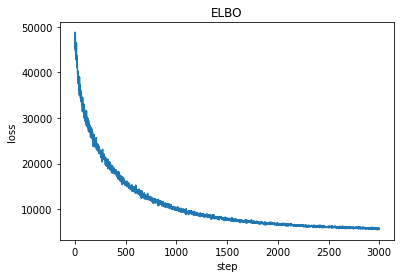

In [19]:
log_prob = model.log_prob(test)

print(f"Negative log prob: {-log_prob}")

## Quality of classificator model
This model can be also tought as a classification model, where prediction is based on most probable anwsers given provided

In [20]:
test_missing = test.copy(deep=True)
test_missing = test_missing.mask(np.random.random(test_missing.shape) < .2)

100%|██████████| 2000/2000 [00:28<00:00, 69.67it/s]


'Input'

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
623832,1.0,4.0,3.0,4.0,3.0,2.0,1.0,5.0,NaN,NaN,...,1.0,5.0,2.0,4.0,1.0,5.0,5.0,5.0,5.0,US
670082,1.0,4.0,2.0,2.0,3.0,3.0,1.0,4.0,2.0,4.0,...,3.0,4.0,2.0,4.0,2.0,4.0,NaN,4.0,3.0,SG
256324,NaN,1.0,NaN,1.0,5.0,1.0,NaN,2.0,4.0,1.0,...,3.0,3.0,3.0,4.0,2.0,4.0,3.0,4.0,NaN,NaN
718894,4.0,1.0,3.0,2.0,4.0,2.0,3.0,NaN,1.0,5.0,...,1.0,4.0,3.0,3.0,2.0,3.0,3.0,5.0,3.0,NaN
828445,5.0,3.0,5.0,NaN,NaN,NaN,5.0,NaN,NaN,3.0,...,3.0,5.0,5.0,NaN,1.0,4.0,2.0,3.0,5.0,DK


'Reconstucted'

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
623832,1.0,4.0,3.0,4.0,3.0,2.0,1.0,5.0,4.0,4.0,...,1.0,5.0,2.0,4.0,1.0,5.0,5.0,5.0,5.0,US
670082,1.0,4.0,2.0,2.0,3.0,3.0,1.0,4.0,2.0,4.0,...,3.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,3.0,SG
256324,3.0,1.0,4.0,1.0,5.0,1.0,4.0,2.0,4.0,1.0,...,3.0,3.0,3.0,4.0,2.0,4.0,3.0,4.0,2.0,NaN
718894,4.0,1.0,3.0,2.0,4.0,2.0,3.0,3.0,1.0,5.0,...,1.0,4.0,3.0,3.0,2.0,3.0,3.0,5.0,3.0,NaN
828445,5.0,3.0,5.0,2.0,3.0,2.0,5.0,4.0,1.0,3.0,...,3.0,5.0,5.0,4.0,1.0,4.0,2.0,3.0,5.0,DK


'Original'

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
623832,1.0,4.0,3.0,4.0,3.0,2.0,1.0,5.0,1.0,5.0,...,1.0,5.0,2.0,4.0,1.0,5.0,5.0,5.0,5.0,US
670082,1.0,4.0,2.0,2.0,3.0,3.0,1.0,4.0,2.0,4.0,...,3.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,3.0,SG
256324,5.0,1.0,4.0,1.0,5.0,1.0,5.0,2.0,4.0,1.0,...,3.0,3.0,3.0,4.0,2.0,4.0,3.0,4.0,4.0,DK
718894,4.0,1.0,3.0,2.0,4.0,2.0,3.0,4.0,1.0,5.0,...,1.0,4.0,3.0,3.0,2.0,3.0,3.0,5.0,3.0,US
828445,5.0,3.0,5.0,3.0,4.0,1.0,5.0,3.0,4.0,3.0,...,3.0,5.0,5.0,5.0,1.0,4.0,2.0,3.0,5.0,DK


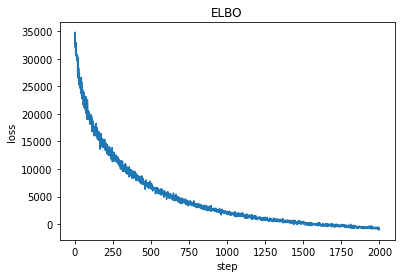

In [21]:
reconstructed = model.predict_missing(test_missing)

display("Input")
display(test_missing.head())

display("Reconstucted")
display(reconstructed.head())

display("Original")
display(test.head())


In [22]:
pred = reconstructed.iloc[:, :50].where(test_missing.isnull()).values.reshape(-1)
real = test.iloc[:, :50].where(test_missing.isnull()).values.reshape(-1)

real = np.clip(real[~pd.isnull(real)], 1.0, 5.0)
pred = pred[~pd.isnull(pred)]

### F1-score 

In [24]:
f1_score(real, pred, average='micro')

0.22512462612163509

### F1-curve
We plot F1 score based on how much of data is missing

In [1]:
f1s = []

for i in range(1, 10):
    percent_missing = i * 0.1
    test_missing = test.copy(deep=True)
    test_missing = test_missing.mask(np.random.random(test_missing.shape) < percent_missing)

    reconstructed = model.predict_missing(test_missing)
    pred = reconstructed.iloc[:, :50].where(test_missing.isnull()).values.reshape(-1)
    real = test.iloc[:, :50].where(test_missing.isnull()).values.reshape(-1)

    real = np.clip(real[~pd.isnull(real)], 1.0, 5.0)
    pred = pred[~pd.isnull(pred)]

    f1s.append(f1_score(real, pred, average='micro'))

NameError: name 'test' is not defined

[Text(0, 0.5, 'Micro F1 score'), Text(0.5, 0, 'Fraction of data missing')]

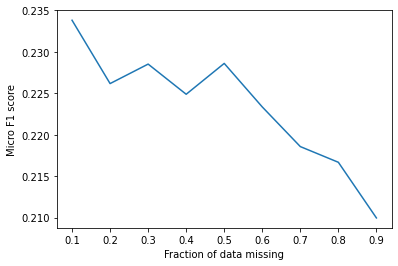

In [30]:
ax = sns.lineplot(np.array(range(1, 10)) * 0.1, y=f1s, )
ax.set(xlabel="Fraction of data missing", ylabel="Micro F1 score")

### Confussion matrix

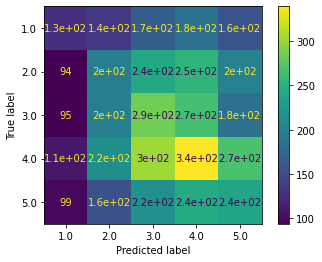

In [292]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(real, pred) ,display_labels=sorted(set(pred)))
disp = disp.plot(include_values=True)
plt.show()